In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
import pennylane as qml
from PIL import Image
import cv2
import matplotlib.pyplot as plt


In [ ]:


torch.manual_seed(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:

dataset_root = "/Users/vinaypatel/Downloads/quantum/dataset/dataset2"
train_dataset = datasets.ImageFolder(root=f"{dataset_root}/train2", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{dataset_root}/valid2", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_root}/test2", transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Number of classes: 4
Training samples: 2620, Validation samples: 1040, Test samples: 12


In [ ]:


n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        weight_shapes = {"weights": (3, n_qubits)}
        self.q_params = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.q_params(x)

class HybridQuantumViT(nn.Module):
    def __init__(self, num_classes):
        super(HybridQuantumViT, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        self.vit.heads = nn.Linear(768, 256)
        self.feature_reduction = nn.Linear(256, 4)
        self.quantum_layer = QuantumLayer()
        self.fc = nn.Linear(4, num_classes)

    def forward(self, x):
        x = self.vit(x)
        x = self.feature_reduction(x)
        x = self.quantum_layer(x)
        x = self.fc(x)
        return x

model = HybridQuantumViT(num_classes).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [ ]:

train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
best_val_acc = 0
patience, trigger_times = 5, 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)


    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "quantum_best.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break

print("Training completed. Best model saved.")


Epoch [1/10], Loss: 1.3268, Train Acc: 59.01%, Val Acc: 19.71%
Epoch [2/10], Loss: 1.2449, Train Acc: 62.79%, Val Acc: 22.88%
Epoch [3/10], Loss: 1.1638, Train Acc: 62.02%, Val Acc: 19.81%
Epoch [4/10], Loss: 1.1012, Train Acc: 67.52%, Val Acc: 39.13%
Epoch [5/10], Loss: 1.0500, Train Acc: 81.79%, Val Acc: 37.02%
Epoch [6/10], Loss: 1.0476, Train Acc: 78.89%, Val Acc: 39.81%
Epoch [7/10], Loss: 0.9901, Train Acc: 84.20%, Val Acc: 39.90%
Epoch [8/10], Loss: 0.9692, Train Acc: 85.00%, Val Acc: 41.06%
Epoch [9/10], Loss: 0.9636, Train Acc: 85.00%, Val Acc: 41.35%
Epoch [10/10], Loss: 0.9593, Train Acc: 85.19%, Val Acc: 41.25%
Training completed. Best model saved.


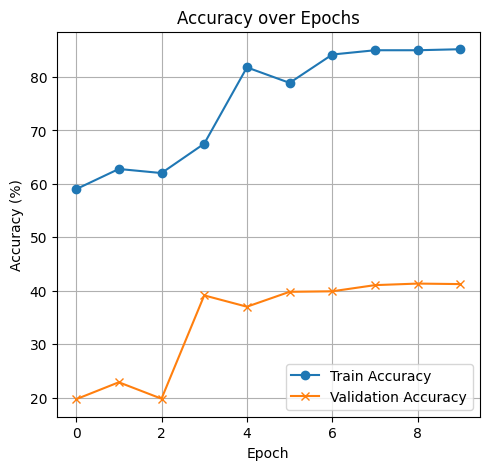

In [ ]:


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='x')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)


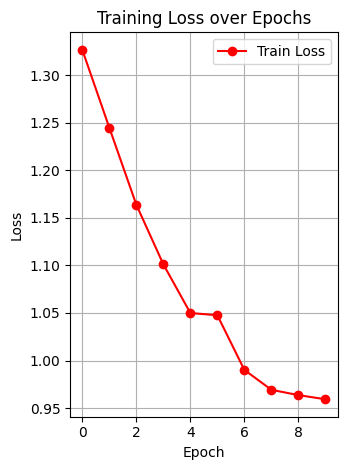

In [7]:

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='red', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

model.load_state_dict(torch.load("quantum_best.pth"))
model.eval()
val_correct, val_total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
        val_total += labels.size(0)
val_accuracy = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Validation Accuracy: 41.44%


In [ ]:

def predict_and_visualize(image_path, model, class_labels):
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    predicted_label = class_labels[predicted.item()]
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_label}", fontsize=14, color="blue")
    plt.show()
    print(f"Model Prediction: {predicted_label}")


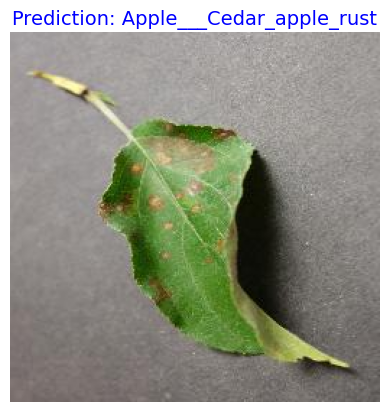

Model Prediction: Apple___Cedar_apple_rust


In [ ]:

disease_classes = train_dataset.classes
image_path = "/Users/vinaypatel/Downloads/quantum/dataset/dataset2/test2/test/AppleCedarRust3.JPG"
predict_and_visualize(image_path, model, disease_classes)


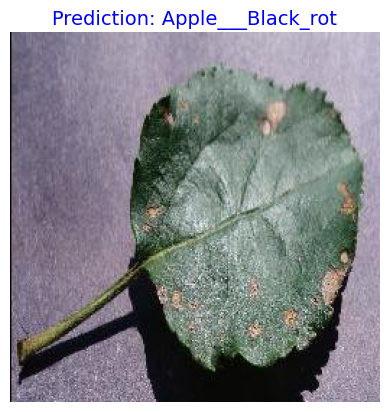

Model Prediction: Apple___Black_rot


In [ ]:

disease_classes = train_dataset.classes
image_path = "/Users/vinaypatel/Downloads/quantum/dataset/dataset2/test2/test/0b8dabb7-5f1b-4fdc-b3fa-30b289707b90___JR_FrgE.S 3047_270deg.JPG"
predict_and_visualize(image_path, model, disease_classes)


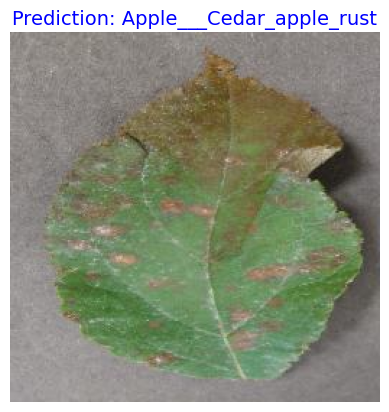

Model Prediction: Apple___Cedar_apple_rust


In [ ]:

disease_classes = train_dataset.classes
image_path = "/Users/vinaypatel/Downloads/quantum/dataset/dataset2/test2/test/AppleCedarRust4.JPG"
predict_and_visualize(image_path, model, disease_classes)


In [25]:
print(disease_classes)


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy']
